In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from PIL import Image
from torchvision.utils import save_image
from torchsummary import summary
from torch.utils.data import Dataset
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import os
from cv2 import imread, createCLAHE
import cv2
from tqdm import tqdm
from glob import glob
%matplotlib inline


In [ ]:

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:

# !pip install opendatasets
# import opendatasets as od
# # od.download("https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation")
# od.download("https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels/data")
# # apikey = '20334f133260ff0831f107dfd0c8508d'
# username = 'aryanali'

In [ ]:
# def test():
#   x = torch.randn((3, 1, 161, 161))
#   model = UNET(1, 1)
#   preds = model(x)
#   print(preds.shape)
#   print(x.shape==preds.shape)

# test()

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform

    # naya code
    self.images = [] #os.listdir(image_dir)
    self.masks = [] # os.listdir(mask_dir)

    for img in os.listdir(image_dir):
      if img.replace(".png", '_mask.png') in os.listdir(mask_dir):
        self.images.append(img)
        self.masks.append(img.replace(".png", '_mask.png'))


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.images[idx])
    # mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", '.png'))
    mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".png", '_mask.png'))
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

    mask[mask==255.0]==1.0 # convert white pixels to 1

    if self.transform is not None:
      augment = self.transform(image=image, mask=mask)
      image = augment["image"]
      mask = augment["mask"]

    return image, mask

In [ ]:
# Hyperparams
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 20
NUM_EPOCHS = 25
NUM_WORKERS = 2
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 480
PIN_MEMORY = True
LOAD_MODEL = False
IMAGE_DIR = "/content/drive/MyDrive/Model/Deeplab/Lung Segmentation/CXR_png"
MASK_DIR = "/content/drive/MyDrive/Model/Deeplab/Lung Segmentation/masks"

In [ ]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),],
        is_check_shapes=False)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),
    ],
)

In [ ]:
 def get_loaders(
    IMAGE_DIR,
    MASK_DIR,
    train_transform,
    val_transform,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
    split=0.8,
    shuffle=True,
  ):

  image_ds = ImageDataset(
      image_dir = IMAGE_DIR,
      mask_dir=MASK_DIR,
      transform=train_transform
  )
  l1, l2 = int(len(image_ds)*split), int(len(image_ds)*(1-split))
  train_ds, val_ds = torch.utils.data.random_split(image_ds, [l1+1, l2])

  train_loader = DataLoader(
      train_ds,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True
  )
  val_loader = DataLoader(
      val_ds,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True
  )

  return train_loader, val_loader

# def check_acc(loader, model, device="cpu"):
def check_acc(loader, model, device="cpu"):
  correct = 0
  pixels = 0
  dice = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      preds = torch.sigmoid(model(x))
      preds = (preds>0.5).float()
      correct += (preds==y).sum()
      pixels += torch.numel(preds)
      dice += (2*(preds*y).sum())/((preds+y).sum()+1e-8)

    print("Score:", dice/len(loader))

    model.train()

def save_img(loader, model, save_folder="/content/drive/MyDrive/MTP/trained_models/Generated", device="cuda"):
  model.eval()
  for idx, (x, y) in enumerate(loader):
    x = x.to(device)
    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds>0.5).float()

    for i in range(len(preds)):
      save_image(preds[i], f"{save_folder}/preds/pred_{idx}_{i}.png")
      save_image(y[i], f"{save_folder}/targets/target_{idx}_{i}.png")

  model.train()


In [ ]:
train_loader, val_loader = get_loaders(
    IMAGE_DIR,
    MASK_DIR,
    train_transform,
    val_transform,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
    shuffle=True,
  )

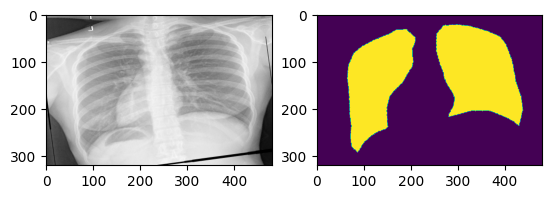

In [ ]:
for batch in train_loader:
    images, labels = batch
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(images[0].permute(1, 2, 0).numpy())
    ax[1].imshow(labels[0].numpy())
    plt.show()
    break

In [ ]:
loss_values=[]
def train_loop(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(DEVICE)
    targets = targets.float().unsqueeze(1).to(DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      preds = model(data)['out']
      loss = loss_fn(preds, targets)
      loss_values.append(loss)
    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm
    loop.set_postfix(loss=loss.item())

In [ ]:
deeplab = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
deeplab.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

deeplab = deeplab.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=deeplab.parameters(), lr=LR) # Create adam optimizer

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 226MB/s]


In [ ]:
# checkpt = torch.load("/content/drive/MyDrive/Model/Deeplab/models/deeplab-01.pth.tar")
# deeplab.load_state_dict(checkpt["state_dict"])
# optimizer.load_state_dict(checkpt["optim_dict"])

In [ ]:
scaler = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS):
  train_loop(train_loader, deeplab, optimizer, loss_fn, scaler)

  # save
  checkpt = {
      "state_dict": deeplab.state_dict(),
      "optim_dict": optimizer.state_dict()
  }

  torch.save(checkpt, "/content/drive/MyDrive/Model/Deeplab/models/deeplab-01.pth.tar")

save_img(train_loader, deeplab)
check_acc(train_loader, deeplab)

100%|██████████| 29/29 [01:26<00:00,  2.99s/it, loss=-1.53e+3]


Score: tensor(1.5660, device='cuda:0')


In [ ]:
checkpt = torch.load("/content/drive/MyDrive/Model/Deeplab/models/deeplab-01.pth.tar")
deeplab.load_state_dict(checkpt["state_dict"])

<All keys matched successfully>

In [ ]:
# Get Dice Scores

import os
import matplotlib.pyplot as plt

def dice_score(mat1, mat2):
  return (2*(mat1*mat2).sum())/(mat1.sum() + mat2.sum())

scores = 0
cnt = 0

image_path = '/content/drive/MyDrive/Model/Deeplab'
pred_images = os.listdir(os.path.join(image_path, 'preds'))

for pred_img in pred_images:
  temp = pred_img.split('_')

  pred_path = os.path.join(image_path, 'preds', pred_img)
  target_path = os.path.join(image_path, 'targets', f'target_{temp[1]}_{temp[2]}')

  try:
    mat1 = plt.imread(pred_path)
    mat2 = plt.imread(target_path)

    dice = dice_score(mat1, mat2)

    scores += dice
    cnt += 1
  except:
    continue

print('Dice Score (DeepLabV3):', scores/cnt) # 0.86

Dice Score (DeepLabV3): 0.8292343542051336


In [ ]:
# save_img(train_loader, deeplab)


(-0.5, 479.5, 479.5, -0.5)

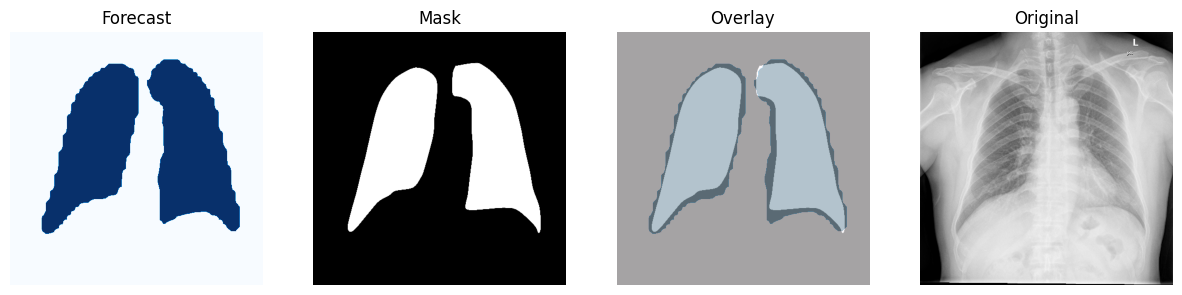

In [ ]:
# get generated mask
import torch
# from archs.unet_arch import UNET, convBlock
from PIL import Image
import numpy as np
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 480
IMAGE_WIDTH = 480
IMAGE_HEIGHT = 320
transform = A.Compose(
    [
        A.Resize(height=IMAGE_WIDTH, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),
    ],
)

model = deeplab

def get_image(img_path):
    img = np.array(Image.open(img_path).convert("RGB"))
    img = transform(image=np.array(img))["image"].unsqueeze(0)
    return img

def get_image_from_array(img):
    img = Image.fromarray(img)
    img = np.array(img.convert("RGB"))
    img = transform(image=np.array(img))["image"].unsqueeze(0)
    return img

def generate_mask_array(img, model, device="cuda"):
    model.eval()
    img = img.to(device)
    with torch.no_grad():
        preds = torch.sigmoid(model(img)['out'])
        preds = (preds>0.5).float()
    # model.train()
    return preds

def generate_mask_img(img, model, device="cuda"):
    # img = get_image(img_path)
    preds = generate_mask_array(img, model, device).cpu()
    mask = Image.fromarray(np.array(preds.cpu().squeeze()*255.0, dtype=np.uint8))
    return mask

img = get_image("/content/drive/MyDrive/Model/Deeplab/Lung Segmentation/CXR_png/CHNCXR_0001_0.png")
mask = get_image("/content/drive/MyDrive/Model/Deeplab/Lung Segmentation/masks/CHNCXR_0001_0_mask.png")
# print(img.shape)

pred = generate_mask_array(img, model, device).cpu()
# print(preds[0])
# print(preds.shape)
op = Image.fromarray(np.array(pred.cpu().squeeze()*255.0, dtype=np.uint8))
op.save("/content/drive/MyDrive/Model/Deeplab/models/op.png")
preds = plt.imread("/content/drive/MyDrive/Model/Deeplab/models/op.png")
# print

fig = plt.figure(figsize=(15, 10))
plt.subplot(2, 4, 1)  # Increase the number of rows to accommodate the file name
# plt.imshow(preds.reshape(IMAGE_WIDTH, IMAGE_HEIGHT), cmap="Blues")
plt.imshow(preds, cmap="Blues")
plt.title("Forecast")
plt.axis("off")

plt.subplot(2, 4, 2)  # Increase the number of rows to accommodate the file name
# plt.imshow(mask.reshape(IMAGE_WIDTH, IMAGE_HEIGHT), cmap="Blues")
plt.imshow(np.transpose(mask[0], (1, 2, 0)), cmap="Blues")
plt.title("Mask")
plt.axis("off")

plt.subplot(2, 4, 3)  # Increase the number of rows to accommodate the file name
plt.imshow(np.transpose(mask[0], (1, 2, 0)), cmap="Blues", alpha=0.5)
plt.imshow(preds, cmap="PuBu", alpha=0.3)
plt.title("Overlay")
plt.axis("off")

plt.subplot(2, 4, 4)  # Increase the number of rows to accommodate the file name
plt.imshow(np.transpose(img[0], (1, 2, 0)), cmap="gray")
plt.title("Original")
plt.axis("off")

In [ ]:
model = deeplab
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
check_acc(train_loader, model)

RuntimeError: ignored

In [ ]:
check_acc(val_loader, model)